In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader


In [2]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])



In [3]:
train_data=datasets.MNIST(root="./data",train=True,download=True,transform=transform)
test_data=datasets.MNIST(root="./data",train=False,download=True,transform=transform)

train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=64,shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.14MB/s]


In [12]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers=nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.fc_layers=nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Linear(128,10)
    )
  def forward(self,x):
    if self.conv_layers is None or self.fc_layers is None:
      raise Exception("model not initialized")
    x=self.conv_layers(x)
    x=self.fc_layers(x)
    return x




In [13]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model=CNN().to(device)

In [15]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [17]:
epochs=5
for epoch in range(epochs):
  model.train()
  running_loss=0
  correct=0
  total=0

  for images,labels in train_loader:
    images,labels=images.to(device),labels.to(device)
    outputs=model(images)
    loss=criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    _,predicted=torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total:.2f}%")

Epoch 5/5, Loss: 0.017987324716178883, Accuracy: 99.41%


In [18]:
model.eval()
with torch.no_grad():
  correct=0
  total=0
  for images,labels in test_loader:
    images,labels=images.to(device),labels.to(device)
    outputs=model(images)

    _,predicted=torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy:{100*correct/total:.2f}%")


Test Accuracy:98.88%


In [19]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()  # evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


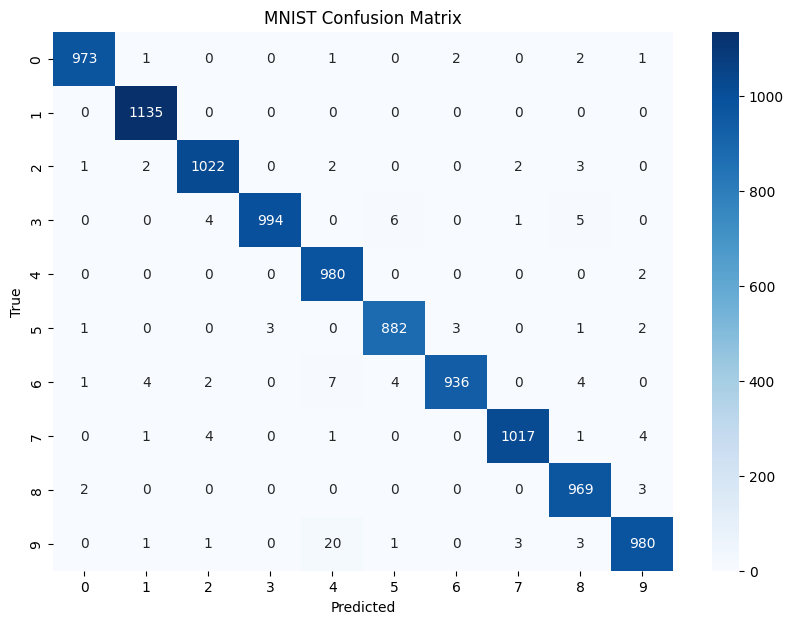

In [20]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MNIST Confusion Matrix")
plt.show()


In [21]:
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.98      0.99      1010
           4       0.97      1.00      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [22]:
import numpy as np
cm = np.array(cm)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"Class {i} Accuracy: {acc*100:.2f}%")


Class 0 Accuracy: 99.29%
Class 1 Accuracy: 100.00%
Class 2 Accuracy: 99.03%
Class 3 Accuracy: 98.42%
Class 4 Accuracy: 99.80%
Class 5 Accuracy: 98.88%
Class 6 Accuracy: 97.70%
Class 7 Accuracy: 98.93%
Class 8 Accuracy: 99.49%
Class 9 Accuracy: 97.13%
